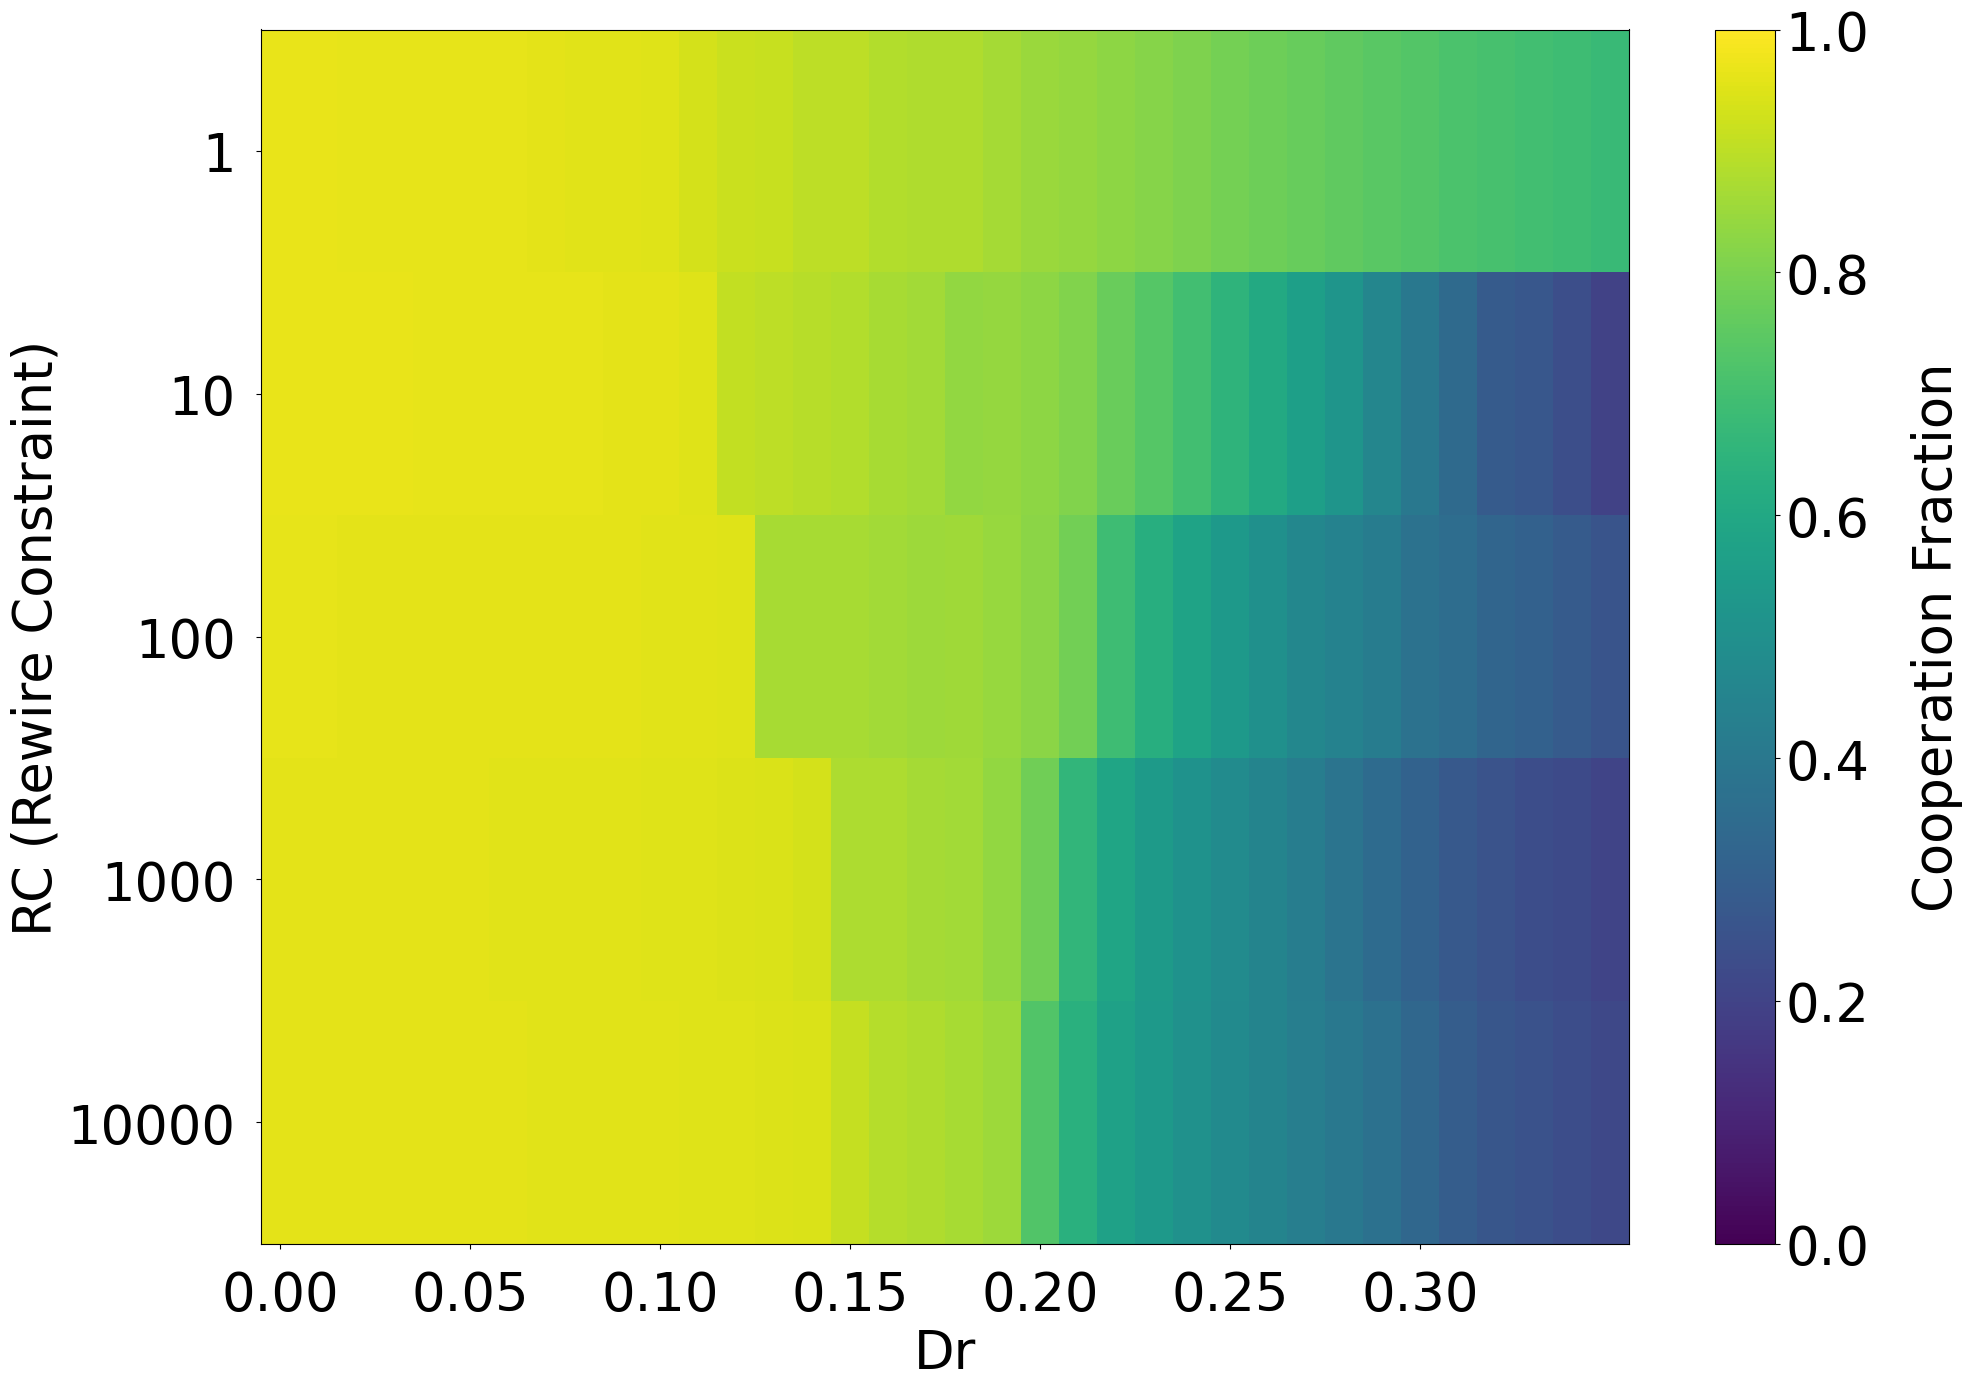

In [ ]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FixedLocator, FixedFormatter

def read_rc_data(file_path: str, rc_label: int) -> pd.DataFrame:
    data = []
    with open(file_path, "r", encoding="utf-8") as f:
        for raw in f:
            line = raw.strip()
            if not line:
                continue
            try:
                m_dr = re.search(r"Dr:\s*([0-9]*\.?[0-9]+)", line)
                m_res = re.search(r"Result:\s*([0-9]*\.?[0-9]+)", line)
                if m_dr and m_res:
                    dr = float(m_dr.group(1))
                    coop = float(m_res.group(1))
                    data.append((dr, coop))
            except ValueError:
                continue

    df = pd.DataFrame(data, columns=["Dr", "Cooperation Rate"])
    df["RC"] = rc_label
    return df

base_dir = os.path.join("..", "sample data")
rc_files = {
    1:     os.path.join(base_dir, "Qlearning_RC1_results.txt"),
    10:    os.path.join(base_dir, "Qlearning_RC10_results.txt"),
    100:   os.path.join(base_dir, "Qlearning_RC100_results.txt"),
    1000:  os.path.join(base_dir, "Qlearning_RC1000_results.txt"),
    10000: os.path.join(base_dir, "Qlearning_RC10000_results.txt"),
}

df_list = [read_rc_data(path, rc) for rc, path in rc_files.items()]
df_all = pd.concat(df_list, ignore_index=True)
df_all["Dr"] = df_all["Dr"].round(2)

rc_order = [1, 10, 100, 1000, 10000]
df_all["RC"] = pd.Categorical(df_all["RC"], categories=rc_order, ordered=True)

heatmap_df = df_all.pivot_table(index="RC", columns="Dr", values="Cooperation Rate", aggfunc="mean")
heatmap_df = heatmap_df.sort_index().sort_index(axis=1)

plt.figure(figsize=(20, 14))
im = plt.imshow(heatmap_df, aspect="auto", interpolation="nearest", vmin=0.0, vmax=1.0)
cbar = plt.colorbar(im)
cbar.set_label("Cooperation Fraction", fontsize=38, labelpad=30)
cbar.ax.tick_params(labelsize=38)

target_dr_values = np.round(np.arange(0.00, 0.31, 0.05), 2)
dr_values = heatmap_df.columns.to_list()
selected_ticks, selected_labels = [], []
for i, real in enumerate(dr_values):
    if np.any(np.isclose(real, target_dr_values)):
        selected_ticks.append(i)
        selected_labels.append(f"{real:.2f}")

ax = plt.gca()
ax.xaxis.set_major_locator(FixedLocator(selected_ticks))
ax.xaxis.set_major_formatter(FixedFormatter(selected_labels))
ax.tick_params(axis="y", pad=15)
ax.tick_params(axis="x", pad=15)

plt.setp(ax.get_xticklabels(), fontsize=38)
plt.yticks(range(len(heatmap_df.index)), [str(r) for r in heatmap_df.index], fontsize=38)
plt.xlabel("Dr", fontsize=38)
plt.ylabel("RC (Rewire Constraint)", fontsize=38)
plt.tight_layout()
plt.show()
